In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import datetime as dt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [167]:
company = "IPOE"

twitter_df = pd.read_csv("twitter_data/spac_aggregate.csv")
stock_df = pd.read_csv("stock_data/{}.csv".format(company))

In [168]:
stock_df['% change tomorrow'] = -stock_df[['Close']].pct_change(periods=-1)
stock_df = stock_df.dropna()
stock_df['Date'] = pd.to_datetime(stock_df['Date']).dt.date
stock_df.head()

,Date,Open,High,Low,Close,Volume,% change tomorrow
0,2020-12-01,10.60,10.740,10.46,10.60,437500,-0.004739
1,2020-12-02,10.65,10.705,10.40,10.55,318100,-0.012476
2,2020-12-03,10.55,10.560,10.40,10.42,448300,-0.000961
3,2020-12-04,10.65,10.650,10.37,10.41,536500,0.019774
4,2020-12-07,10.69,10.800,10.44,10.62,824200,0.022999


In [169]:
# getting the dates in order
twitter_df["datetime"] = twitter_df[['timestamp']].apply(datetime.fromtimestamp,axis=1)
twitter_df['date'] = twitter_df['datetime'].dt.date

In [170]:
#adding sentiment in
analyzer = SentimentIntensityAnalyzer()
twitter_df["sentiment_scores"] = twitter_df[['text']].apply(analyzer.polarity_scores,axis=1)
twitter_df["sentiment"] = twitter_df[['text']].apply(lambda x: analyzer.polarity_scores(x)['compound'],axis=1)

# Simple analysis

In [171]:
twitter_df = twitter_df[twitter_df['text'].str.contains(company)]

In [172]:
twitter_df.shape

(126, 12)

In [173]:
#this might not be too telling since there has been a lot of spam posts of late 
#(maybe filter to get rid of posts that seem like spam)
filtered_df = twitter_df[(twitter_df['retweets'] >=0) & (twitter_df['likes'] >= 0)]
means = filtered_df[["likes", "retweets", "replies", "sentiment", "date"]].groupby(['date']).mean()
means = means.dropna()

In [174]:
means.shape

(53, 4)

In [175]:
merged = pd.merge(stock_df.set_index('Date'), means, left_index=True, right_index=True)

In [176]:
merged['sentiment'].clip(upper=10000).corr(merged['% change tomorrow'])

0.062228198575376786

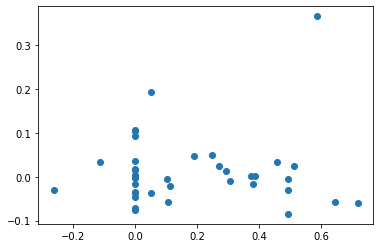

In [177]:
plt.scatter(merged['sentiment'].clip(upper=10000), merged['% change tomorrow'])

# backtesting

In [178]:
money = 100
indices = []
profits = []

for index, row in merged.iterrows():
    if row['likes'] > 25 and row['sentiment'] >= 0:
        profits.append(money*(1+row['% change tomorrow']))
        indices.append(index)
        money *= (1+row['% change tomorrow'])
    elif row['sentiment'] < 0 and row['likes'] > 25:
        profits.append(money/(1+row['% change tomorrow']))
        indices.append(index)
        money /= (1+row['% change tomorrow'])
        pass

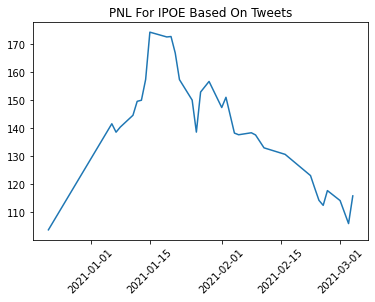

In [181]:
plt.title("PNL For IPOE Based On Tweets")
plt.plot(indices, profits)
plt.xticks(rotation=45)
plt.show()


In [182]:
def create_merged_df(ticker):
    twitter_df = pd.read_csv("twitter_data/spac_aggregate.csv")
    stock_df = pd.read_csv("stock_data/{}.csv".format(ticker))
    
    stock_df['% change tomorrow'] = -stock_df[['Close']].pct_change(periods=-1)
    stock_df = stock_df.dropna()
    stock_df['Date'] = pd.to_datetime(stock_df['Date']).dt.date
    stock_df.head()
    
    # getting the dates in order
    twitter_df["datetime"] = twitter_df[['timestamp']].apply(datetime.fromtimestamp,axis=1)
    twitter_df['date'] = twitter_df['datetime'].dt.date
    
    #adding sentiment in
    analyzer = SentimentIntensityAnalyzer()
    twitter_df["sentiment_scores"] = twitter_df[['text']].apply(analyzer.polarity_scores,axis=1)
    twitter_df["sentiment"] = twitter_df[['text']].apply(lambda x: analyzer.polarity_scores(x)['compound'],axis=1)
    
    twitter_df = twitter_df[twitter_df['text'].str.contains(company)]
    
    #this might not be too telling since there has been a lot of spam posts of late 
    #(maybe filter to get rid of posts that seem like spam)
    filtered_df = twitter_df[(twitter_df['retweets'] >=0) & (twitter_df['likes'] >= 0)]
    means = filtered_df[["likes", "retweets", "replies", "sentiment", "date"]].groupby(['date']).mean()
    means = means.dropna()
    
    merged = pd.merge(stock_df.set_index('Date'), means, left_index=True, right_index=True)
    
    return merged

In [ ]:
tickers = ["SPCE", "SOAC", "SNPR", "SHLL", "PSTH", "NOVSU", "JWS", "DKNG", "CLA", "CCIV", "BTAQ", "BFT", "APSG"]
merged = create_merged_df("IPOE")
for ticker in tickers:
    merged = merged.append(create_merged_df(ticker))

In [ ]:
merged.tail()

In [ ]:
merged.index.unique()

In [ ]:
money = 100
indices = []
profits = []



for date in sorted(merged.index.unique()):
    print(date)
    sub = merged[merged.index == date]
    r = sub.loc[sub['replies'].idxmax()].iloc[0]
    if r['sentiment'] > 0:
        profits.append(money*(1+r['% change tomorrow']))
        indices.append(date)
        money *= (1+row['% change tomorrow'])
    elif r['sentiment'] < 0:
        profits.append(money/(1+row['% change tomorrow']))
        indices.append(date)
        money /= (1+row['% change tomorrow'])
    

In [ ]:
plt.title("Investing in the Top Engaged Tweets Across Spacs")
plt.ylabel("Cumulative Profits")
plt.xlabel("Date")
plt.plot(indices, profits)
plt.xticks(rotation=45)
plt.show()